In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._backward = lambda:None
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self) -> str:
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            # See power rule here: https://en.wikipedia.org/wiki/Power_rule
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    
    # a / b is the same as below ...
    # a * 1 / b
    # a * b**-1
    def __truediv__(self, other):
        return self * other**-1
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out  = Value(t, (self,), 'tanh')
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [98]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [13]:
from graphviz import Digraph

def trace(root):
    # build a  set of all nodes and edges in a graph
    nodes, edges, = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the grap, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label= n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

# A neuron
![A single neuron](./one_neuron.jpg)
# Activation function Tan h
![Tan H](./tanh.png)


![Derivative of tanh](./derivative_of_tanh.png)

In [119]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1w1 + x2w2'
n = x1w1_plus_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

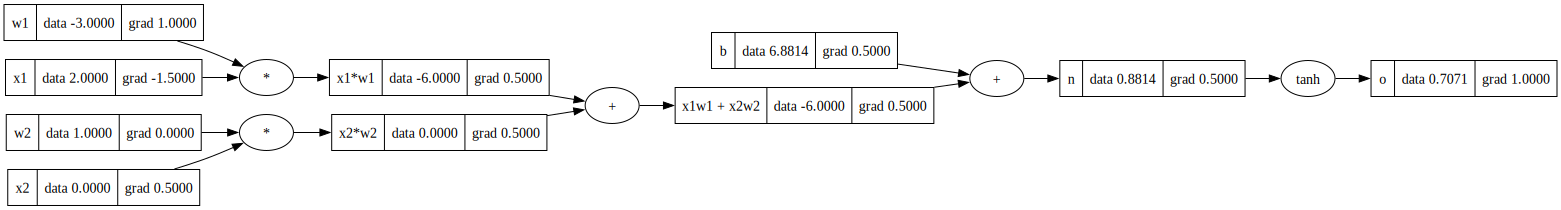

In [120]:
draw_dot(o)

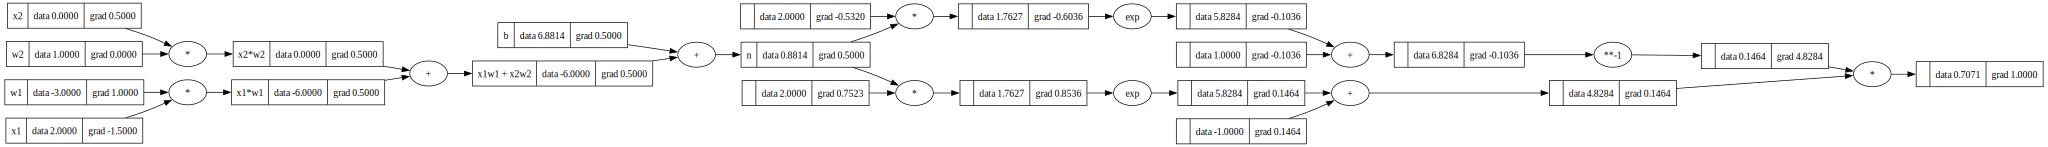

In [121]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1w1 + x2w2'
n = x1w1_plus_x2w2 + b; n.label = 'n'
# ---- Reimplement tanh using e**2*x  - 1 / e**2*x + 1
o =  ((2 * n).exp() - 1) / ((2 * n).exp() + 1)
# ----

o.backward()
draw_dot(o)